# classifiers comparision

In [2]:
## Custom functions
import sys
sys.path.append('../common')
from analysis_utils import prettify_plots, plot_seqlen_distribution
from notebook_utils import table_of_contents, table_from_dict
table_of_contents('classifiers_comparison.ipynb')

<h3>Table of contents</h3>

[classifiers comparision](#classifiers-comparision)
- [Functions](#Functions)
- [TRI classifiers](#TRI-classifiers)
- [MoR classifiers](#MoR-classifiers)

In [3]:
# IMPORTS
# Display
from IPython.display import display, HTML
from IPython.display import Markdown as md
import matplotlib.pyplot as plt
import matplotlib.patches as patches

# Basics
import numpy as np
import pandas as pd
import os
import json
import re
import ast

# Set pandas display option for floating-point numbers
pd.options.display.float_format = '{:.2f}'.format

In [13]:
# Define variables
metrics = ['accuracy', 'f1_score', 'recall', 'precision'] #, 'auroc' doesn't really seem very useful, it just goes to 1
columns = ['model_name'] + metrics + [m+'_std' for m in metrics]
MODELS_FOLDER = '../../classifiers_training/saved_models/'

## Functions

In [59]:
# FUNCTIONS
def load_params(file_path):
    with open(file_path) as json_file:
        return json.load(json_file)

def get_meaned_comparison_df(models_path, models_list):
    
    # Get the type of classifier from the models_path
    TRI = 'TRI' in models_path
    MoR = 'MoR' in models_path

    def process_metrics(report_df):
        metrics_df = report_df.drop(columns=['confusion', 'fold', 'probabilities', 'labels', 'val_texts'])  

        if TRI:
            # Average all columns
            metrics_mean = metrics_df.mean().to_frame().T
            metrics_std = metrics_df.std().add_suffix('_std').to_frame().T
            metrics_df = pd.concat([metrics_mean, metrics_std], axis=1)

        elif MoR:
            # Get the mean of the 5 folds per label, with 'decs' decimals
            decs = 2
            metrics_mean = metrics_df.apply(lambda x: [np.mean(np.stack(x), axis=0)] , axis=0)
            metrics_mean = metrics_mean.map(lambda x: [round(num, decs) for num in x]) 

            # Get the std of the 5 folds per label, using ceil with 'decs' decimals
            metrics_std = metrics_df.apply(lambda x: [np.std(np.stack(x), axis=0)] , axis=0).add_suffix('_std')
            metrics_std = metrics_std.map(lambda x: [round(np.ceil(num*10**decs)*10**-decs, decs) for num in x]) 
            
            metrics_df = pd.concat([metrics_mean, metrics_std], axis=1) 
            
            # Average the metrics per label, leaving 1 value 
            metrics_mean_mean = metrics_mean.map(lambda x: np.mean(x)).add_suffix('_mean')
            metrics_df = pd.concat([metrics_df, metrics_mean_mean], axis=1) 
            
        else:
            print('Sth went wrong')
        return metrics_df

    def process_confusion_matrices(report_df):
        confusion = report_df[['confusion']].apply(lambda x: [np.sum(np.stack(x), axis=0)] , axis=0)
        return confusion
            
    dfs = []
    for model_name in models_list:
        params = load_params(os.path.join(models_path, model_name, "train_params.json"))
        
        # Convert report_df to DataFrame and process
        report_df = pd.DataFrame(params['report_df'])

        # Average / sum metrics
        confusion = process_confusion_matrices(report_df)
        metrics = process_metrics(report_df)
        metrics = metrics.join(confusion)
        
        # Add model information
        metrics['pretrained_model'] = params['pretrained_model']
        metrics['weights'] = '_'.join(map(str, params['train_loss_weights']))
        metrics['model_name'] = model_name
        metrics['num_epochs'] = params['num_epochs']
        for preds in ['probabilities', 'labels', 'val_texts']:
            metrics[preds] = report_df[preds]

        dfs.append(metrics)
        
    return pd.concat(dfs, ignore_index=True)

def highlight_max_num(col):
    '''Highlight the max number per column'''
    col = round(col, 2)
    max_num = max(col)
    col = col.replace(max_num, f'<b>{max_num}</b>')
    return col

def plot_evaluation_parameters(ax, df, title, legend=True):
    '''
    df: DataFrame with ['model_name']
    '''
    if 'model_name' not in df.columns:
        raise ValueError("DataFrame must have column 'model_name'")
    # Get the relevant columns
    
    # Melt the DataFrame to make it long-form
    df_melted = df.melt(id_vars='model_name', var_name='metric', value_name='score')
    
    # Plot each metric for each model
    for model_name in df['model_name'].unique():
        subset = df_melted[df_melted['model_name'] == model_name]
        ax.plot(subset['metric'], subset['score'], marker='o', label=model_name)
    
    # Add labels and title
    ax.set_title(title)
    ax.set_ylabel('Score')
    if legend:
        ax.legend()

## TRI classifiers

In [14]:
!ls "{MODELS_FOLDER}TRI_classifier/"

In [15]:
TRI_folder = MODELS_FOLDER + 'TRI_classifier/'
TRI_models = os.listdir(TRI_folder)
TRI_models.remove('before_3rd_validation')

TRI_df = get_meaned_comparison_df(TRI_folder, TRI_models).sort_values(by='f1_score', ascending=False)
TRI_display = TRI_df.copy()
TRI_display[metrics] = TRI_display[metrics].apply(lambda x: highlight_max_num(x))

display(HTML(TRI_display[columns].to_html(escape=False)))

ValueError: list.remove(x): x not in list

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


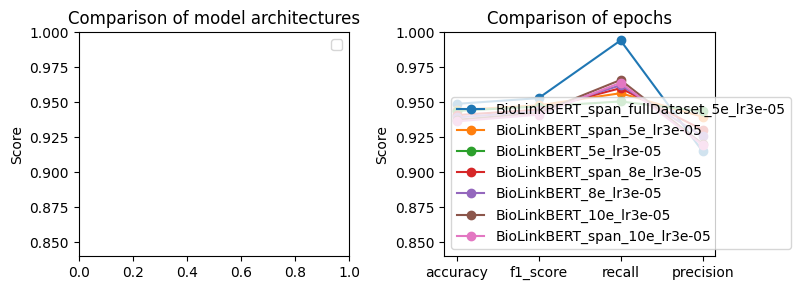

In [62]:
# Plot
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(8, 3))
display(HTML('<h4>Comparison of evaluation parameters</h4>'))

for ax, df, title in [[ax1, TRI_df[TRI_df['num_epochs'] == 3], "Comparison of model architectures"], 
                      [ax2, TRI_df[TRI_df['pretrained_model'] == 'BioLinkBERT'], "Comparison of epochs"]]:
    df_metrics = df[['model_name'] + metrics]
    plot_evaluation_parameters(ax, df_metrics, title)
    ax.set_ylim(0.84, 1)
plt.tight_layout()    
plt.show()

## MoR classifiers

In [12]:
!ls "{MODELS_FOLDER}MoR_classifier/"

ls: cannot access '../../classifiers_training/saved_models//MoR_classifier/before_validation/': No such file or directory


In [64]:
MoR_columns = ['model_name'] + [m+'_mean' for m in metrics] + metrics + [m+'_std' for m in metrics]

MoR_folder = MODELS_FOLDER + 'MoR_classifier/'
MoR_models = os.listdir(MoR_folder)
MoR_models.remove('before_3rd_validation')

MoR_df = get_meaned_comparison_df(MoR_folder, MoR_models).sort_values(by='f1_score_mean', ascending=False)
#MoR_df.set_index('model_name', inplace=True)

MoR_display = MoR_df.copy()
MoR_display[[m+'_mean' for m in metrics]] = MoR_display[[m+'_mean' for m in metrics]].apply(lambda x: highlight_max_num(x))

display(HTML(MoR_display[MoR_columns].set_index('model_name').to_html(escape=False)))


,accuracy_mean,f1_score_mean,recall_mean,precision_mean,accuracy,f1_score,recall,precision,accuracy_std,f1_score_std,recall_std,precision_std
model_name,,,,,,,,,,,,
BioLinkBERT_span_fullDataset_5e_lr3e-05,0.97,0.96,0.97,0.96,"[0.94, 0.98, 0.98]","[0.96, 0.97, 0.96]","[0.94, 0.98, 0.98]","[0.99, 0.96, 0.94]","[0.0, 0.0, 0.0]","[0.0, 0.0, 0.0]","[0.0, 0.0, 0.0]","[0.0, 0.0, 0.0]"
BioLinkBERT_span_5e_lr3e-05,0.93,0.93,0.93,0.93,"[0.9, 0.96, 0.93]","[0.93, 0.94, 0.92]","[0.9, 0.96, 0.93]","[0.96, 0.92, 0.92]","[0.03, 0.01, 0.03]","[0.02, 0.01, 0.01]","[0.03, 0.01, 0.03]","[0.02, 0.02, 0.02]"
BioLinkBERT_span_8e_lr3e-05,0.93,0.93,0.93,0.93,"[0.89, 0.96, 0.93]","[0.92, 0.94, 0.93]","[0.89, 0.96, 0.93]","[0.95, 0.92, 0.92]","[0.05, 0.02, 0.02]","[0.02, 0.02, 0.02]","[0.05, 0.02, 0.02]","[0.03, 0.03, 0.03]"
BiomedNLP_span_5e_lr3e-05,0.93,0.93,0.93,0.93,"[0.89, 0.96, 0.94]","[0.92, 0.94, 0.93]","[0.89, 0.96, 0.94]","[0.96, 0.92, 0.91]","[0.03, 0.02, 0.02]","[0.02, 0.01, 0.02]","[0.03, 0.02, 0.02]","[0.02, 0.01, 0.03]"
BiomedNLP-large_span_5e_lr3e-05,0.93,0.93,0.93,0.93,"[0.89, 0.96, 0.93]","[0.92, 0.94, 0.92]","[0.89, 0.96, 0.93]","[0.95, 0.93, 0.91]","[0.03, 0.01, 0.02]","[0.02, 0.02, 0.02]","[0.03, 0.01, 0.02]","[0.02, 0.02, 0.02]"
BioLinkBERT_5e_lr3e-05,0.93,0.93,0.93,0.93,"[0.89, 0.96, 0.93]","[0.92, 0.94, 0.92]","[0.89, 0.96, 0.93]","[0.96, 0.92, 0.91]","[0.03, 0.01, 0.02]","[0.01, 0.01, 0.01]","[0.03, 0.01, 0.02]","[0.02, 0.02, 0.02]"
BioLinkBERT_span_10e_lr3e-05,0.92,0.93,0.92,0.93,"[0.89, 0.96, 0.92]","[0.92, 0.94, 0.92]","[0.89, 0.96, 0.92]","[0.96, 0.92, 0.91]","[0.04, 0.02, 0.03]","[0.02, 0.01, 0.02]","[0.04, 0.02, 0.03]","[0.02, 0.03, 0.04]"
BioLinkBERT_8e_lr3e-05,0.93,0.93,0.93,0.92,"[0.91, 0.95, 0.93]","[0.92, 0.94, 0.92]","[0.91, 0.95, 0.93]","[0.94, 0.93, 0.9]","[0.03, 0.02, 0.02]","[0.02, 0.01, 0.02]","[0.03, 0.02, 0.02]","[0.01, 0.02, 0.04]"
BiomedNLP_5e_lr3e-05,0.93,0.92,0.93,0.92,"[0.88, 0.96, 0.94]","[0.92, 0.94, 0.91]","[0.88, 0.96, 0.94]","[0.96, 0.92, 0.89]","[0.02, 0.01, 0.02]","[0.01, 0.01, 0.01]","[0.02, 0.01, 0.02]","[0.02, 0.01, 0.02]"


No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


ValueError: Length of values (0) does not match length of index (4)

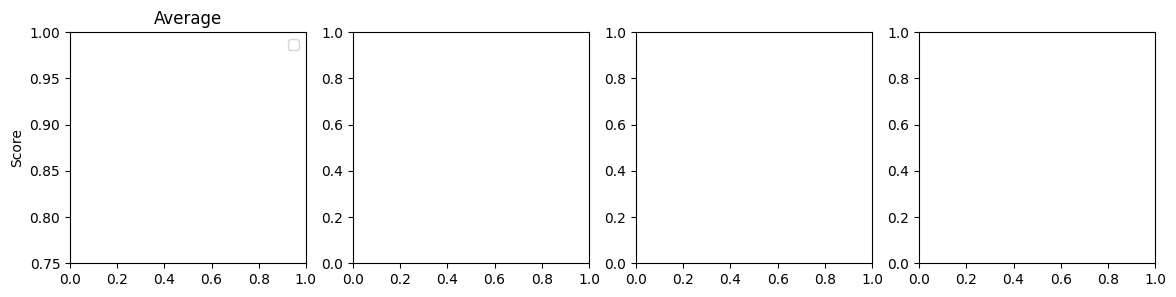

In [65]:
display(HTML('<h3>Comparison of evaluation parameters per label</h3>'))
# Plot different subsets of the data
for mask, heading, min_ylim in [[MoR_df['num_epochs'] == 3, 'On different architectures', 0.75],
                                [MoR_df['pretrained_model'] == 'BioLinkBERT', 'On different number of epochs', 0.825]]:
    MoR_df_subset = MoR_df[mask]
    MoR_df_subset.set_index('model_name', inplace=True)
    labels = ['Undefined', 'Activation', 'Repression']
    fig, axs = plt.subplots(1, 4, figsize=(14, 3))
    display(HTML(f'<h4>{heading}</h4>'))

    # Plot over labels
    MoR_metrics = MoR_df_subset[[m+'_mean' for m in metrics]].reset_index()
    MoR_metrics.columns = [col.replace('_mean', '') for col in MoR_metrics.columns]
    plot_evaluation_parameters(axs[0], MoR_metrics, 'Average') 
    axs[0].set_ylim(min_ylim, 1)
    
    # Plot labels
    for i, title in enumerate(labels):
        MoR_label_metrics = MoR_df_subset[metrics].apply(lambda x: [y[i] for y in x]).reset_index()
        plot_evaluation_parameters(axs[i+1], MoR_label_metrics, title, legend=False)
        axs[i+1].set_ylim(min_ylim, 1)   
    plt.tight_layout()    
    plt.show()

In [ ]:
# Print the worst predicted labels

labels_names = {0: 'Undefined', 1: 'Activation', 2: 'Repression'}
pd.set_option('display.max_colwidth', 1000)

preds_list = ['probabilities', 'labels', 'val_texts']
preds_df = MoR_df.loc[['BioLinkBERT']][preds_list].explode(preds_list)
preds_df['correct_prob'] = preds_df.apply(lambda row: row['probabilities'][row['labels']], axis=1)
preds_df['predicted'] = preds_df.apply(lambda row: np.argmax(row['probabilities']), axis=1)
preds_df['predicted'] = preds_df['predicted'].map(labels_names)
preds_df['correct'] = preds_df['labels'].map(labels_names)


preds_df = preds_df.sort_values('correct_prob')[['val_texts', 'correct_prob', 'correct', 'predicted']]
display(preds_df[preds_df['correct_prob'] < 0.05])